# Exercise 3 - CNN for language classification

In [ ]:
import csv
import re

import numpy as np
import pandas as pd

from io import StringIO
import requests
import pandas as pd
import numpy as np
import re
import bisect

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split

from collections import Counter


from sklearn.utils import resample

from tqdm.notebook import tqdm

torch.manual_seed(1)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
import nltk
import math
from nltk.tokenize import word_tokenize
!pip install emoji
import emoji
nltk.download('punkt')

     |████████████████████████████████| 51kB 2.0MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=6044d64ba738c03e8f3d4dc19734f50c137855b254393f33379c4dcc7be24090
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Preprocessing the data

In [ ]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [ ]:
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [ ]:
df_train_dev = load_dataset(url_train_dev)
df_test = load_dataset(url_test)

function to cut off the smallest classes that have less than 100 samples

In [ ]:
def cutoff_small_classes(df, threshold=100):
    sizes = df.groupby('label').size()
    small_classes = sizes[sizes <= threshold].index.values.tolist()
    
    for ind, tweet in df.iterrows():
        if tweet.label in small_classes:
            tweet.label = 'other'

resample the training data such that each class has the same amount of samples (6000 samples in our case)

In [ ]:
def resample_training_set(df, n):
    sizes = df.groupby('label').size().sort_values()
    dfs = []
    for class_ in sizes.keys():
        dfs.append(resample(df[df.label == class_], n_samples=n))
    return pd.concat(dfs)

In [ ]:
cutoff_small_classes(df_train_dev, 100)

In [ ]:
resampled = resample_training_set(df_train_dev, 6000)

In [ ]:
resampled = resampled.reset_index()

In [ ]:
resampled['tweet'] = resampled['tweet'].astype('str')
resampled['tweet'][1]

'3 hari ke arah puasa penuh . phhew'

In [ ]:
class Vocabulary:
    """Assigns and keeps indices to (as well as counts of) a vocabulary 
    of tokens, which can be searched and updated"""

    UNKNOWN_TOKEN = '<UNK>'

    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        
        # Building two dicts one that mapes tokens to indices and anither one that maps indices to tokens
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}

        self.add_token(Vocabulary.UNKNOWN_TOKEN)

    def add_token(self, token):
        """adds a token to the vocab and creats an index for it"""
        
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def lookup_token(self, token):
        """given a token it find the corresponding index
        if the token is not in the vocab, it raises a key error"""

        if token not in self._token_to_idx:
            raise KeyError("the token (%s) is not in the Vocabulary" % token)
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """gets a token given an index, if the index does not exists
        it raises a key error"""

        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, df_test, preprocessor=None, cutoff=0, seq_len=300):
        self.cutoff = cutoff
        self._seq_len = seq_len

        self.x_test = []
        self.y_test = df_test.label

        # prepare the test set, which will not be part of the vocabulary nor any other
        # statistics
        test_texts = df_test.tweet
        for i in range(len(test_texts)):
            if preprocessor:
                sentence = " ".join(preprocessor.preprocess(test_texts[i]))
                n_grams = [sentence[i] for i in range(len(sentence))]
            
            # tweets that are longer than a certain maximum will be exluded
            if len(n_grams) <= self._seq_len:
                self.x_test.append(n_grams)
            else:
                self.x_test.append(n_grams[:200])

        # loads the dataset and (after preprocessing) creates a list of tokens,
        # arranged in texts (e.g., different reviews are regarded as different
        # texts), thus preventing overlapping contexts between reviews/texts.
        texts = df.tweet
        self.labels = df.label
        self._texts = []
        self.max_token = []
        for i in range(len(texts)):
            if preprocessor:
                sentence = " ".join(preprocessor.preprocess(texts[i]))
                n_grams = [sentence[i] for i in range(len(sentence))]

            # tweets that are longer than a certain maximum will be exluded
            if len(n_grams) <= self._seq_len:
                self._texts.append(n_grams)
            else:
                self._texts.append(n_grams[:200])
            
            self.max_token.append(len(n_grams))
            
        # fills the sentences with 0 such that all have same length
        self._padding_sentences()

        # holds a counter for the tokens. used later for cutting off, and 
        # finding the most common words in the dataset
        self.counter = Counter()
        self._count()

        # creates the Vocabulary (index)
        self._unk_count = 0
        self.vocabulary = self._create_vocabulary()

        #self._texts = self._padding_sentences(self._texts)
        self._token_to_idx()

        # split the dataset into train and test
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self._texts, self.labels, test_size=0.1)

        self._encode_labels()

        self.x_train = tf.convert_to_tensor(self.x_train)
        self.x_val = tf.convert_to_tensor(self.x_val)
        self.x_test = tf.convert_to_tensor(self.x_test)
    
    def switch_mode(self, new_mode):
        self.mode = new_mode

    def _count(self):
        for text in self._texts:
            self.counter.update(text)

    def unknown_count(self):
        return self._unk_count

    def _create_vocabulary(self):
        """create vocabulary with all words of the dataset which appear more frequent than cutoff threshold"""
        vocabulary = Vocabulary()
        for i, text in enumerate(self._texts):
            for j, token in enumerate(text):
                if self.counter[token] < self.cutoff:
                    self._texts[i][j] = Vocabulary.UNKNOWN_TOKEN
                    self._unk_count += 1
                else:
                    vocabulary.add_token(token)
        return vocabulary
    
    def _encode_labels(self):
        """first encode the labels and map them to numbers, then the labels
        are converted into one-hot encoding"""
        label_encoder = LabelEncoder()
        label_one_hot = OneHotEncoder(sparse=False)

        # fit encoder to train labels and transform those to numbers
        y_train = label_encoder.fit_transform(self.y_train)

        # overwrite unknown labels in the validation and test set
        y_val = ['und' if s not in label_encoder.classes_ else s for s in self.y_val]
        y_val = label_encoder.transform(y_val)

        y_test = ['und' if s not in label_encoder.classes_ else s for s in self.y_test]
        y_test = label_encoder.transform(y_test)

        self.y_train = y_train.tolist()
        self.y_val = y_val.tolist()
        self.y_test = y_test.tolist()

        self.test_labels_numbers = self.y_test
        self.labels_encoded = list(label_encoder.classes_)

        # transforming the encoded lables to one-hot format
        self.y_train = np.array(self.y_train).reshape((len(self.y_train), 1))
        self.y_val = np.array(self.y_val).reshape((len(self.y_val), 1))
        self.y_test = np.array(self.y_test).reshape((len(self.y_test), 1))

        self.y_train = label_one_hot.fit_transform(self.y_train)
        self.y_val = label_one_hot.transform(self.y_val)
        self.y_test = label_one_hot.transform(self.y_test)

        self.y_train = tf.convert_to_tensor(self.y_train.tolist())
        self.y_val = tf.convert_to_tensor(self.y_val.tolist())
        self.y_test = tf.convert_to_tensor(self.y_test.tolist())
   
    def _padding_sentences(self):
        # Each sentence which does not fulfill the required length
        # it's padded with the index 0
        for idx, el in enumerate(self._texts):
            l = el
            while len(l) < self._seq_len:
                l.append(0)
            self._texts[idx] = l
        
        for idx, el in enumerate(self.x_test):
            l = el
            while len(l) < self._seq_len:
                l.append(0)
            self.x_test[idx] = l

    
    def _token_to_idx(self):
        """ this function replaces the words on the sentences with the respective 
        idx number from the vocab """
        for j, text in enumerate(self._texts):
            for i, word in enumerate(text):
                if not word == 0:
                    idx = self.vocabulary.lookup_token(word)
                    self._texts[j][i] = idx
            self._texts[j] = text
        
        for j, text in enumerate(self.x_test):
            for i, word in enumerate(text):
                if not word == 0:
                    try:
                        idx = self.vocabulary.lookup_token(word)
                    except KeyError:
                        idx = 0
                    self.x_test[j][i] = idx
            self.x_test[j] = text

    def __len__(self):
        return len(self.y_train)

In [ ]:
from nltk.tokenize import TweetTokenizer

class Preprocessing:

    EMOJI_PATTERN = emoji.get_emoji_regexp()

    def __init__(self):
        self.tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
        self._tokens = None

    def preprocess(self, text):
        self._text = text
        self._text = self._remove_emojis(self._text)
        self._text = self._remove_urls(self._text)
        self._text = self._remove_hashtags(self._text)
        self._text = self._remove_mentions(self._text)
        self._text = self._clean_text(self._text)
        return self.tknzr.tokenize(self._text)

    def _clean_text(self, text):
        # Removes special symbols and just keep
        # words in lower or upper form
        self._text = self._text.lower()
        self._text = re.sub(r'[!.,-?\'\"()/%@#\d]+', '', self._text)
        return self._text
    
    def _remove_emojis(self, text):
        return Preprocessing.EMOJI_PATTERN.sub('', text)
    
    def _remove_urls(self, text):
        return re.sub(r'https?://[\S]+', '', text)
    
    def _remove_hashtags(self, text):
        return re.sub(r'#[\S]+', '', text)
    
    def _remove_mentions(self, text):
        return re.sub(r'@[\S]+', '', text)

### create the dataset based on the three classes above: 

* vocabulary keeps count of the vocab (this time it is characters not words!)
* TextDataset builds the dataset and converts the tweets to tensors
* preprocessing class that preprocesses the tweets (explained in lapreport)

In [ ]:
dataset = TextDataset(resampled, df_test, Preprocessing(), seq_len=200)

In [ ]:
dataset.x_train

<tf.Tensor: shape=(97200, 200), dtype=int32, numpy=
array([[ 8,  3,  3, ...,  0,  0,  0],
       [24,  6, 20, ...,  0,  0,  0],
       [24,  6,  8, ...,  0,  0,  0],
       ...,
       [12, 11, 20, ...,  0,  0,  0],
       [ 9,  4, 15, ...,  0,  0,  0],
       [ 1,  6,  8, ...,  0,  0,  0]], dtype=int32)>

In [ ]:
dataset.y_train

<tf.Tensor: shape=(97200, 18), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
dataset.x_val

<tf.Tensor: shape=(10800, 200), dtype=int32, numpy=
array([[  19,    3,    1, ...,    0,    0,    0],
       [  12,    3,   20, ...,    0,    0,    0],
       [  83,    5,   25, ...,    0,    0,    0],
       ...,
       [  28,    5, 2200, ...,    0,    0,    0],
       [  26,    6,   20, ...,    0,    0,    0],
       [1008,    5, 1010, ...,    0,    0,    0]], dtype=int32)>

In [ ]:
dataset.y_val

<tf.Tensor: shape=(10800, 18), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
dataset.x_test

<tf.Tensor: shape=(13279, 200), dtype=int32, numpy=
array([[  13,   11,    2, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [  15,    3,    3, ...,    0,    0,    0],
       ...,
       [   1,   15,    5, ...,    0,    0,    0],
       [2411, 2643, 2613, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)>

In [ ]:
dataset.y_test

<tf.Tensor: shape=(13279, 18), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

here we can see that the index in the vocab actually only returns one char

In [ ]:
dataset.vocabulary.lookup_index(1234)

'忘'

# 5 model combinations
### We ran more than 5 models and included the most interesting ones in the report, the models below are to show how we did it. 

# Model 1 / 5

In [ ]:
# this is responsible for early stopping as was recommended
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model = models.Sequential()

model.add(layers.Embedding(len(dataset.vocabulary), output_dim=32, input_length=200))
model.add(layers.Reshape(target_shape=(200, 32, 1)))
model.add(layers.Conv2D(kernel_size=2, filters=32, padding='same', activation='relu', strides=1))
model.add(layers.MaxPool2D(strides=1, padding='same'))
model.add(layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu', strides=1))
model.add(layers.MaxPool2D(strides=1, padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(18, activation='softmax')) 

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           141664    
_________________________________________________________________
reshape (Reshape)            (None, 200, 32, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 32, 32)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 200, 32, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 32, 128)      36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 32, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 819200)            0

In [ ]:
model.fit(x = dataset.x_train, y = dataset.y_train, batch_size = 50, verbose=1, epochs=50, validation_data=(dataset.x_val, dataset.y_val), callbacks=[callback])

Epoch 1/50
1944/1944 [==============================] - 162s 84ms/step - loss: 2.9400 - accuracy: 0.0555 - val_loss: 2.8922 - val_accuracy: 0.0534
Epoch 2/50
1944/1944 [==============================] - 162s 83ms/step - loss: 2.8921 - accuracy: 0.0544 - val_loss: 2.8912 - val_accuracy: 0.0563
Epoch 3/50
1944/1944 [==============================] - 162s 83ms/step - loss: 2.8919 - accuracy: 0.0558 - val_loss: 2.8908 - val_accuracy: 0.0566
Epoch 4/50
1944/1944 [==============================] - 162s 84ms/step - loss: 2.8917 - accuracy: 0.0551 - val_loss: 2.8924 - val_accuracy: 0.0554
Epoch 5/50
1944/1944 [==============================] - 162s 83ms/step - loss: 2.8917 - accuracy: 0.0549 - val_loss: 2.8917 - val_accuracy: 0.0566
Epoch 6/50
1944/1944 [==============================] - 162s 83ms/step - loss: 2.8917 - accuracy: 0.0551 - val_loss: 2.8910 - val_accuracy: 0.0554


In [ ]:
model.evaluate(dataset.x_test, dataset.y_test)

415/415 [==============================] - 6s 14ms/step - loss: 2.8849 - accuracy: 0.0083


[2.884892225265503, 0.008283756673336029]

In [ ]:
pred = np.argmax(model.predict(dataset.x_test), axis=-1)

# Model 2 / 5

In [ ]:
# this is responsible for early stopping as was recommended
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model2 = models.Sequential()

model2.add(layers.Embedding(len(dataset.vocabulary), output_dim=32, input_length=200))
model2.add(layers.Reshape(target_shape=(200, 32, 1)))
model2.add(layers.Conv2D(kernel_size=2, filters=32, padding='same', activation='relu', strides=1))
model2.add(layers.MaxPool2D(strides=1, padding='same'))
model2.add(layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu', strides=1))
model2.add(layers.MaxPool2D(strides=1, padding='same'))
model2.add(layers.Flatten())
model2.add(layers.Dense(200, activation='relu'))
model2.add(layers.Dense(18, activation='softmax')) 

model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           141664    
_________________________________________________________________
reshape_2 (Reshape)          (None, 200, 32, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 200, 32, 32)       160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 200, 32, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 32, 128)      36992     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 200, 32, 128)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 819200)           

In [ ]:
model2.fit(x = dataset.x_train, y = dataset.y_train, batch_size = 50, verbose=1, epochs=50, validation_data=(dataset.x_val, dataset.y_val), callbacks=[callback])

Epoch 1/50
1944/1944 [==============================] - 175s 90ms/step - loss: 1.0090 - accuracy: 0.6815 - val_loss: 0.5269 - val_accuracy: 0.8444
Epoch 2/50
1944/1944 [==============================] - 172s 89ms/step - loss: 0.4155 - accuracy: 0.8735 - val_loss: 0.3453 - val_accuracy: 0.8911
Epoch 3/50
1944/1944 [==============================] - 172s 89ms/step - loss: 0.2778 - accuracy: 0.9176 - val_loss: 0.2710 - val_accuracy: 0.9230
Epoch 4/50
1944/1944 [==============================] - 172s 88ms/step - loss: 0.2004 - accuracy: 0.9398 - val_loss: 0.1936 - val_accuracy: 0.9435
Epoch 5/50
1944/1944 [==============================] - 171s 88ms/step - loss: 0.1495 - accuracy: 0.9551 - val_loss: 0.1649 - val_accuracy: 0.9529
Epoch 6/50
1944/1944 [==============================] - 171s 88ms/step - loss: 0.1149 - accuracy: 0.9659 - val_loss: 0.1755 - val_accuracy: 0.9515
Epoch 7/50
1944/1944 [==============================] - 171s 88ms/step - loss: 0.0901 - accuracy: 0.9732 - val_loss: 0

In [ ]:
model2.evaluate(dataset.x_test, dataset.y_test)

415/415 [==============================] - 6s 14ms/step - loss: 1.2013 - accuracy: 0.8471


[1.2013276815414429, 0.847051739692688]

In [ ]:
pred2 = np.argmax(model2.predict(dataset.x_test), axis=-1)

# Model 3 / 5

In [ ]:
# this is responsible for early stopping as was recommended
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model3 = models.Sequential()

model3.add(layers.Embedding(len(dataset.vocabulary), output_dim=32, input_length=200))
model3.add(layers.Reshape(target_shape=(200, 32, 1)))
model3.add(layers.Conv2D(kernel_size=2, filters=32, padding='same', activation='relu', strides=1))
#model3.add(layers.MaxPool2D(strides=1, padding='same'))
model3.add(layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu', strides=1))
#model3.add(layers.MaxPool2D(strides=1, padding='same'))
model3.add(layers.Flatten())
model3.add(layers.Dense(200, activation='relu'))
model3.add(layers.Dense(18, activation='softmax')) 

model3.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 32)           141664    
_________________________________________________________________
reshape_4 (Reshape)          (None, 200, 32, 1)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 200, 32, 32)       160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 200, 32, 128)      36992     
_________________________________________________________________
flatten_4 (Flatten)          (None, 819200)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               163840200 
_________________________________________________________________
dense_9 (Dense)              (None, 18)               

In [ ]:
model3.fit(x = dataset.x_train, y = dataset.y_train, batch_size = 50, verbose=1, epochs=50, validation_data=(dataset.x_val, dataset.y_val), callbacks=[callback])

Epoch 1/50
1944/1944 [==============================] - 157s 81ms/step - loss: 0.8676 - accuracy: 0.7320 - val_loss: 0.3686 - val_accuracy: 0.8899
Epoch 2/50
1944/1944 [==============================] - 155s 80ms/step - loss: 0.2649 - accuracy: 0.9221 - val_loss: 0.2170 - val_accuracy: 0.9390
Epoch 3/50
1944/1944 [==============================] - 155s 80ms/step - loss: 0.1543 - accuracy: 0.9538 - val_loss: 0.1680 - val_accuracy: 0.9531
Epoch 4/50
1944/1944 [==============================] - 155s 80ms/step - loss: 0.0989 - accuracy: 0.9701 - val_loss: 0.1472 - val_accuracy: 0.9615
Epoch 5/50
1944/1944 [==============================] - 155s 80ms/step - loss: 0.0693 - accuracy: 0.9794 - val_loss: 0.1136 - val_accuracy: 0.9696
Epoch 6/50
1944/1944 [==============================] - 155s 79ms/step - loss: 0.0455 - accuracy: 0.9866 - val_loss: 0.1169 - val_accuracy: 0.9728
Epoch 7/50
1944/1944 [==============================] - 154s 79ms/step - loss: 0.0330 - accuracy: 0.9902 - val_loss: 0

In [ ]:
model3.evaluate(dataset.x_test, dataset.y_test)

415/415 [==============================] - 5s 13ms/step - loss: 1.1168 - accuracy: 0.8431


[1.1167963743209839, 0.8431357741355896]

In [ ]:
pred3 = np.argmax(model3.predict(dataset.x_test), axis=-1)
pred3

array([ 2, 17,  2, ...,  3,  7, 17])

# Model 4 / 5

In [ ]:
# this is responsible for early stopping as was recommended
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model4 = models.Sequential()

model4.add(layers.Embedding(len(dataset.vocabulary), output_dim=32, input_length=200))
model4.add(layers.Reshape(target_shape=(200, 32, 1)))
model4.add(layers.Conv2D(kernel_size=5, filters=32, padding='same', activation='relu', strides=1))
#model4.add(layers.MaxPool2D(strides=1, padding='same'))
model4.add(layers.Conv2D(kernel_size=5, filters=128, padding='same', activation='relu', strides=1))
#model4.add(layers.MaxPool2D(strides=1, padding='same'))
model4.add(layers.Flatten())
model4.add(layers.Dense(200, activation='relu'))
model4.add(layers.Dense(18, activation='softmax')) 

model4.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 32)           141664    
_________________________________________________________________
reshape_7 (Reshape)          (None, 200, 32, 1)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 200, 32, 32)       832       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 200, 32, 128)      102528    
_________________________________________________________________
flatten_7 (Flatten)          (None, 819200)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 200)               163840200 
_________________________________________________________________
dense_15 (Dense)             (None, 18)               

In [ ]:
model4.fit(x = dataset.x_train, y = dataset.y_train, batch_size = 50, verbose=1, epochs=50, validation_data=(dataset.x_val, dataset.y_val), callbacks=[callback])

Epoch 1/50
1944/1944 [==============================] - 190s 98ms/step - loss: 0.8954 - accuracy: 0.7139 - val_loss: 0.4571 - val_accuracy: 0.8626
Epoch 2/50
1944/1944 [==============================] - 189s 97ms/step - loss: 0.3341 - accuracy: 0.9012 - val_loss: 0.2629 - val_accuracy: 0.9220
Epoch 3/50
1944/1944 [==============================] - 188s 97ms/step - loss: 0.1933 - accuracy: 0.9433 - val_loss: 0.1830 - val_accuracy: 0.9456
Epoch 4/50
1944/1944 [==============================] - 187s 96ms/step - loss: 0.1209 - accuracy: 0.9640 - val_loss: 0.1334 - val_accuracy: 0.9631
Epoch 5/50
1944/1944 [==============================] - 187s 96ms/step - loss: 0.0783 - accuracy: 0.9767 - val_loss: 0.1173 - val_accuracy: 0.9665
Epoch 6/50
1944/1944 [==============================] - 187s 96ms/step - loss: 0.0532 - accuracy: 0.9841 - val_loss: 0.1056 - val_accuracy: 0.9747
Epoch 7/50
1944/1944 [==============================] - 187s 96ms/step - loss: 0.0351 - accuracy: 0.9904 - val_loss: 0

In [ ]:
model4.evaluate(dataset.x_test, dataset.y_test)

415/415 [==============================] - 8s 19ms/step - loss: 1.3276 - accuracy: 0.8464


[1.3275991678237915, 0.8464492559432983]

# Model 5 / 5

In [ ]:
# this is responsible for early stopping as was recommended
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model5 = models.Sequential()

model5.add(layers.Embedding(len(dataset.vocabulary), output_dim=32, input_length=200))
model5.add(layers.Reshape(target_shape=(200, 32, 1)))
model5.add(layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', strides=1))
model5.add(layers.MaxPool2D(strides=1, padding='same'))
model5.add(layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu', strides=1))
model5.add(layers.MaxPool2D(strides=1, padding='same'))
model5.add(layers.Flatten())
model5.add(layers.Dense(200, activation='relu'))
model5.add(layers.Dense(18, activation='softmax')) 

model5.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           142208    
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 32, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 32, 32)       320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 200, 32, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 200, 32, 128)      36992     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 200, 32, 128)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 819200)           

In [ ]:
model5.fit(x = dataset.x_train, y = dataset.y_train, batch_size = 100, verbose=1, epochs=50, validation_data=(dataset.x_val, dataset.y_val), callbacks=[callback])

Epoch 1/50
972/972 [==============================] - 231s 237ms/step - loss: 1.2713 - accuracy: 0.5921 - val_loss: 0.7764 - val_accuracy: 0.7365
Epoch 2/50
972/972 [==============================] - 230s 237ms/step - loss: 0.6014 - accuracy: 0.8110 - val_loss: 0.4643 - val_accuracy: 0.8569
Epoch 3/50
972/972 [==============================] - 230s 237ms/step - loss: 0.4130 - accuracy: 0.8742 - val_loss: 0.3478 - val_accuracy: 0.8956
Epoch 4/50
972/972 [==============================] - 230s 236ms/step - loss: 0.3069 - accuracy: 0.9077 - val_loss: 0.2812 - val_accuracy: 0.9137
Epoch 5/50
972/972 [==============================] - 230s 236ms/step - loss: 0.2387 - accuracy: 0.9280 - val_loss: 0.2240 - val_accuracy: 0.9365
Epoch 6/50
972/972 [==============================] - 230s 236ms/step - loss: 0.1917 - accuracy: 0.9416 - val_loss: 0.1883 - val_accuracy: 0.9444
Epoch 7/50
972/972 [==============================] - 230s 236ms/step - loss: 0.1545 - accuracy: 0.9534 - val_loss: 0.1646 -

In [ ]:
model5.evaluate(dataset.x_test, dataset.y_test)

415/415 [==============================] - 15s 35ms/step - loss: 1.2893 - accuracy: 0.8602


[1.2892601490020752, 0.8601551055908203]

# Create Confusion Matrix

We created the confusion matrix for model 4. We create two different confusion matrices to be able to see which labels get confused most often. All of the interpretation can be found in the lab report.

In [ ]:
pred4 = np.argmax(model4.predict(dataset.x_test), axis=-1)
pred4.tolist() # the labels that we got from the model

array([ 2, 17,  2, ..., 12,  7, 17])

In [ ]:
np.array(dataset.test_labels_numbers) # the actual labels in numbers

array([ 2, 17,  2, ...,  3,  7, 17])

In [ ]:
true_labels = dataset.test_labels_numbers

In [ ]:
dataset.labels_encoded

['ar',
 'de',
 'en',
 'es',
 'fr',
 'id',
 'it',
 'ja',
 'ko',
 'ms',
 'nl',
 'other',
 'pt',
 'ru',
 'th',
 'tl',
 'tr',
 'und']

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

mapping the classes to their number representation that we created in the dataset class

In [ ]:
labels = {}
for idx, label in enumerate(dataset.labels_encoded):
    labels[str(idx)] = label


Converting the classes in the list to numbers

In [ ]:
p4 = pred4.tolist()
for idx, c in enumerate(p4):
    p4[idx] = labels[str(c)]

for idx, c in enumerate(true_labels):
    true_labels[idx] = labels[str(c)]

It is difficult to properly interpret the figures as they use the numbers instead of the labels, but we can see that not many classes got confused in general. Below we have a solution to be able to interpret it better.

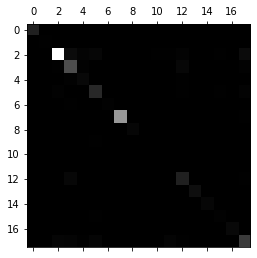

In [ ]:
conf_mx = confusion_matrix(true_labels, p4, labels=dataset.labels_encoded)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
def create_better_confusion_matrix(pred, true):
    conf_mx = confusion_matrix(true, pred, labels=dataset.labels_encoded, normalize="true")
    np.fill_diagonal(conf_mx, 0)
    
    plt.matshow(conf_mx, cmap=plt.cm.gray)
    plt.show()
    
    return conf_mx

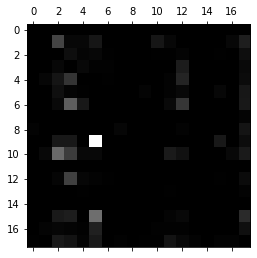

In [ ]:
ncm = create_better_confusion_matrix(p4, true_labels)

As the above matrices are not very clear because they use the numbers instead of the class labels we created the following fucntion:
The following function enabels us to see which label got confused with which other how many times (as percentage)

In [ ]:
for ind, label in enumerate(dataset.labels_encoded):
    most = dataset.labels_encoded[np.argmax(ncm[ind, :])]
    val = np.max(ncm[ind, :])
    print(f'{label}\t~~\t{most}\t({val*100:.2f}%)')

ar	~~	ko	(0.19%)
de	~~	en	(18.00%)
en	~~	und	(3.89%)
es	~~	pt	(7.59%)
fr	~~	es	(14.29%)
id	~~	und	(6.12%)
it	~~	es	(25.00%)
ja	~~	und	(1.17%)
ko	~~	und	(5.45%)
ms	~~	id	(67.74%)
nl	~~	en	(27.91%)
other	~~	ar	(0.00%)
pt	~~	es	(17.02%)
ru	~~	und	(0.82%)
th	~~	ar	(0.00%)
tl	~~	id	(29.21%)
tr	~~	id	(8.62%)
und	~~	en	(6.79%)


# TALOS
in this part we use talos to search for the best model and create the heatmap

In [ ]:
!python -c 'import talos' || pip install talos

Using TensorFlow backend.
2020-11-06 14:39:16.282067: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


in the following cells we set up the model and the parameters for talos to use, note that the model is exactly the same as the models above

In [ ]:
from talos import Scan
from talos import Reporting
from tensorflow.keras import callbacks

In [ ]:
callback = callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [ ]:
p = {'optimizer': ['Adam', 'RMSprop'],
     'batch_size': [100],
     'strides': [1],
     'padding': ['same'],
     'kernel_size': [2, 3],
     'filters': [32, 64, 128],
     'epochs': [30]}

In [ ]:
def model(x_train, y_train, x_val, y_val, params):
    model = models.Sequential()
    model.add(layers.Embedding(len(dataset.vocabulary),
                            output_dim=32, input_length=200))
    model.add(layers.Reshape(target_shape=(200, 32, 1)))
    model.add(layers.Conv2D(activation='relu',
                            strides=params['strides'], 
                            padding=params['padding'],
                            kernel_size=params['kernel_size'],
                            filters=params['filters']
                            ))
    model.add(layers.MaxPool2D(strides=params['strides'], 
                            padding=params['padding'],))
    model.add(layers.Conv2D(activation='relu',
                            strides=params['strides'], 
                            padding=params['padding'],
                            kernel_size=params['kernel_size'],
                            filters=params['filters']
                            ))
    model.add(layers.MaxPool2D(strides=params['strides'], 
                            padding=params['padding'],))
    model.add(layers.Flatten())
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(18, activation='softmax'))

    
    model.compile(optimizer=params['optimizer'], 
                            loss='categorical_crossentropy', 
                            metrics=['accuracy'],)
    
    history = model.fit(x_train, 
                    y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[callback])
    
    
    return history, model

In [ ]:
scan = Scan(dataset.x_train, 
     dataset.y_train, 
     model=model, 
     params=p,
     print_params=True, 
     reduction_metric="val_loss",
     experiment_name='lang_class',
     x_val=dataset.x_val,
     y_val=dataset.y_val)

  0%|          | 0/12 [00:00<?, ?it/s]

{'batch_size': 100, 'epochs': 30, 'filters': 32, 'kernel_size': 2, 'optimizer': 'Adam', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 44s 45ms/step - loss: 0.5836 - accuracy: 0.8183 - val_loss: 0.2049 - val_accuracy: 0.9401
Epoch 2/30
972/972 [==============================] - 44s 45ms/step - loss: 0.1306 - accuracy: 0.9615 - val_loss: 0.1040 - val_accuracy: 0.9709
Epoch 3/30
972/972 [==============================] - 45s 46ms/step - loss: 0.0645 - accuracy: 0.9801 - val_loss: 0.0910 - val_accuracy: 0.9762
Epoch 4/30
972/972 [==============================] - 45s 46ms/step - loss: 0.0433 - accuracy: 0.9867 - val_loss: 0.0865 - val_accuracy: 0.9803
Epoch 5/30
972/972 [==============================] - 46s 47ms/step - loss: 0.0290 - accuracy: 0.9913 - val_loss: 0.0971 - val_accuracy: 0.9818


  8%|▊         | 1/12 [03:51<42:30, 231.88s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 32, 'kernel_size': 2, 'optimizer': 'RMSprop', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 55s 57ms/step - loss: 0.6796 - accuracy: 0.7851 - val_loss: 0.2071 - val_accuracy: 0.9367
Epoch 2/30
972/972 [==============================] - 55s 57ms/step - loss: 0.1423 - accuracy: 0.9567 - val_loss: 0.1188 - val_accuracy: 0.9683
Epoch 3/30
972/972 [==============================] - 55s 57ms/step - loss: 0.0664 - accuracy: 0.9798 - val_loss: 0.1050 - val_accuracy: 0.9750
Epoch 4/30
972/972 [==============================] - 55s 57ms/step - loss: 0.0366 - accuracy: 0.9889 - val_loss: 0.0970 - val_accuracy: 0.9806
Epoch 5/30
972/972 [==============================] - 55s 57ms/step - loss: 0.0209 - accuracy: 0.9937 - val_loss: 0.1019 - val_accuracy: 0.9818


 17%|█▋        | 2/12 [08:29<40:56, 245.63s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 32, 'kernel_size': 3, 'optimizer': 'Adam', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 49s 51ms/step - loss: 0.6752 - accuracy: 0.7838 - val_loss: 0.2057 - val_accuracy: 0.9422
Epoch 2/30
972/972 [==============================] - 50s 51ms/step - loss: 0.1232 - accuracy: 0.9620 - val_loss: 0.1418 - val_accuracy: 0.9583
Epoch 3/30
972/972 [==============================] - 50s 51ms/step - loss: 0.0533 - accuracy: 0.9832 - val_loss: 0.0974 - val_accuracy: 0.9744
Epoch 4/30
972/972 [==============================] - 50s 51ms/step - loss: 0.0347 - accuracy: 0.9892 - val_loss: 0.0942 - val_accuracy: 0.9793
Epoch 5/30
972/972 [==============================] - 50s 51ms/step - loss: 0.0206 - accuracy: 0.9937 - val_loss: 0.0917 - val_accuracy: 0.9822
Epoch 6/30
972/972 [==============================] - 50s 51ms/step - loss: 0.0180 - accuracy: 0.9949 - val_loss: 0.1102 - val_accuracy: 0.9806


 25%|██▌       | 3/12 [13:30<39:18, 262.10s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 32, 'kernel_size': 3, 'optimizer': 'RMSprop', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 57s 59ms/step - loss: 0.6584 - accuracy: 0.7908 - val_loss: 0.1869 - val_accuracy: 0.9425
Epoch 2/30
972/972 [==============================] - 57s 58ms/step - loss: 0.1254 - accuracy: 0.9620 - val_loss: 0.0934 - val_accuracy: 0.9722
Epoch 3/30
972/972 [==============================] - 57s 59ms/step - loss: 0.0544 - accuracy: 0.9837 - val_loss: 0.0898 - val_accuracy: 0.9802
Epoch 4/30
972/972 [==============================] - 56s 58ms/step - loss: 0.0290 - accuracy: 0.9919 - val_loss: 0.0848 - val_accuracy: 0.9823
Epoch 5/30
972/972 [==============================] - 57s 58ms/step - loss: 0.0169 - accuracy: 0.9952 - val_loss: 0.1049 - val_accuracy: 0.9855


 33%|███▎      | 4/12 [18:16<35:53, 269.24s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 64, 'kernel_size': 2, 'optimizer': 'Adam', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 91s 94ms/step - loss: 0.7600 - accuracy: 0.7595 - val_loss: 0.2369 - val_accuracy: 0.9299
Epoch 2/30
972/972 [==============================] - 91s 93ms/step - loss: 0.1587 - accuracy: 0.9524 - val_loss: 0.1238 - val_accuracy: 0.9648
Epoch 3/30
972/972 [==============================] - 91s 94ms/step - loss: 0.0738 - accuracy: 0.9768 - val_loss: 0.0986 - val_accuracy: 0.9744
Epoch 4/30
972/972 [==============================] - 91s 94ms/step - loss: 0.0463 - accuracy: 0.9853 - val_loss: 0.0901 - val_accuracy: 0.9804
Epoch 5/30
972/972 [==============================] - 91s 94ms/step - loss: 0.0328 - accuracy: 0.9902 - val_loss: 0.0949 - val_accuracy: 0.9790


 42%|████▏     | 5/12 [25:53<37:59, 325.68s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 64, 'kernel_size': 2, 'optimizer': 'RMSprop', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 104s 107ms/step - loss: 0.6764 - accuracy: 0.7912 - val_loss: 0.1848 - val_accuracy: 0.9434
Epoch 2/30
972/972 [==============================] - 104s 107ms/step - loss: 0.1166 - accuracy: 0.9651 - val_loss: 0.1105 - val_accuracy: 0.9682
Epoch 3/30
972/972 [==============================] - 104s 107ms/step - loss: 0.0500 - accuracy: 0.9844 - val_loss: 0.0847 - val_accuracy: 0.9804
Epoch 4/30
972/972 [==============================] - 104s 107ms/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 0.0859 - val_accuracy: 0.9823


 50%|█████     | 6/12 [32:51<35:20, 353.42s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 64, 'kernel_size': 3, 'optimizer': 'Adam', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 102s 105ms/step - loss: 0.7377 - accuracy: 0.7661 - val_loss: 0.2812 - val_accuracy: 0.9161
Epoch 2/30
972/972 [==============================] - 101s 104ms/step - loss: 0.1845 - accuracy: 0.9430 - val_loss: 0.1562 - val_accuracy: 0.9524
Epoch 3/30
972/972 [==============================] - 101s 104ms/step - loss: 0.0952 - accuracy: 0.9688 - val_loss: 0.1270 - val_accuracy: 0.9642
Epoch 4/30
972/972 [==============================] - 101s 104ms/step - loss: 0.0638 - accuracy: 0.9795 - val_loss: 0.1249 - val_accuracy: 0.9682
Epoch 5/30
972/972 [==============================] - 101s 104ms/step - loss: 0.0425 - accuracy: 0.9864 - val_loss: 0.1371 - val_accuracy: 0.9678


 58%|█████▊    | 7/12 [41:21<33:21, 400.26s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 64, 'kernel_size': 3, 'optimizer': 'RMSprop', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 116s 119ms/step - loss: 0.5683 - accuracy: 0.8224 - val_loss: 0.1460 - val_accuracy: 0.9563
Epoch 2/30
972/972 [==============================] - 116s 119ms/step - loss: 0.0905 - accuracy: 0.9723 - val_loss: 0.0811 - val_accuracy: 0.9780
Epoch 3/30
972/972 [==============================] - 116s 119ms/step - loss: 0.0354 - accuracy: 0.9897 - val_loss: 0.0870 - val_accuracy: 0.9817


 67%|██████▋   | 8/12 [47:10<25:39, 384.93s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 128, 'kernel_size': 2, 'optimizer': 'Adam', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 203s 209ms/step - loss: 0.7954 - accuracy: 0.7476 - val_loss: 0.2658 - val_accuracy: 0.9169
Epoch 2/30
972/972 [==============================] - 202s 208ms/step - loss: 0.1746 - accuracy: 0.9475 - val_loss: 0.1481 - val_accuracy: 0.9587
Epoch 3/30
972/972 [==============================] - 203s 209ms/step - loss: 0.0832 - accuracy: 0.9747 - val_loss: 0.1312 - val_accuracy: 0.9641
Epoch 4/30
972/972 [==============================] - 203s 209ms/step - loss: 0.0540 - accuracy: 0.9835 - val_loss: 0.1282 - val_accuracy: 0.9673
Epoch 5/30
972/972 [==============================] - 203s 209ms/step - loss: 0.0329 - accuracy: 0.9901 - val_loss: 0.1068 - val_accuracy: 0.9761
Epoch 6/30
972/972 [==============================] - 203s 209ms/step - loss: 0.0303 - accuracy: 0.9912 - val_loss: 0.1122 - val_accuracy: 0.9786


 75%|███████▌  | 9/12 [1:07:32<31:48, 636.25s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 128, 'kernel_size': 2, 'optimizer': 'RMSprop', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 231s 237ms/step - loss: 0.5951 - accuracy: 0.8159 - val_loss: 0.1729 - val_accuracy: 0.9549
Epoch 2/30
972/972 [==============================] - 230s 236ms/step - loss: 0.0969 - accuracy: 0.9705 - val_loss: 0.0878 - val_accuracy: 0.9768
Epoch 3/30
972/972 [==============================] - 229s 236ms/step - loss: 0.0400 - accuracy: 0.9875 - val_loss: 0.0718 - val_accuracy: 0.9826
Epoch 4/30
972/972 [==============================] - 228s 235ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.0897 - val_accuracy: 0.9848


 83%|████████▎ | 10/12 [1:22:53<24:03, 721.54s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 128, 'kernel_size': 3, 'optimizer': 'Adam', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 198s 204ms/step - loss: 0.7998 - accuracy: 0.7408 - val_loss: 0.3966 - val_accuracy: 0.8808
Epoch 2/30
972/972 [==============================] - 196s 202ms/step - loss: 0.2769 - accuracy: 0.9139 - val_loss: 0.2200 - val_accuracy: 0.9314
Epoch 3/30
972/972 [==============================] - 196s 202ms/step - loss: 0.1388 - accuracy: 0.9567 - val_loss: 0.1340 - val_accuracy: 0.9610
Epoch 4/30
972/972 [==============================] - 196s 202ms/step - loss: 0.0915 - accuracy: 0.9703 - val_loss: 0.1340 - val_accuracy: 0.9637


 92%|█████████▏| 11/12 [1:36:03<12:22, 742.24s/it]

{'batch_size': 100, 'epochs': 30, 'filters': 128, 'kernel_size': 3, 'optimizer': 'RMSprop', 'padding': 'same', 'strides': 1}
Epoch 1/30
972/972 [==============================] - 225s 231ms/step - loss: 0.6788 - accuracy: 0.7925 - val_loss: 0.1425 - val_accuracy: 0.9596
Epoch 2/30
972/972 [==============================] - 223s 230ms/step - loss: 0.0884 - accuracy: 0.9734 - val_loss: 0.0745 - val_accuracy: 0.9784
Epoch 3/30
972/972 [==============================] - 223s 230ms/step - loss: 0.0371 - accuracy: 0.9889 - val_loss: 0.0637 - val_accuracy: 0.9837
Epoch 4/30
972/972 [==============================] - 223s 229ms/step - loss: 0.0198 - accuracy: 0.9945 - val_loss: 0.0818 - val_accuracy: 0.9857


100%|██████████| 12/12 [1:51:02<00:00, 555.19s/it]


## Analyzing the talos run and creating the heatmap

In [ ]:
from talos import Deploy, Analyze

In [ ]:
a = Analyze('/content/lang_class/110620170629.csv')

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


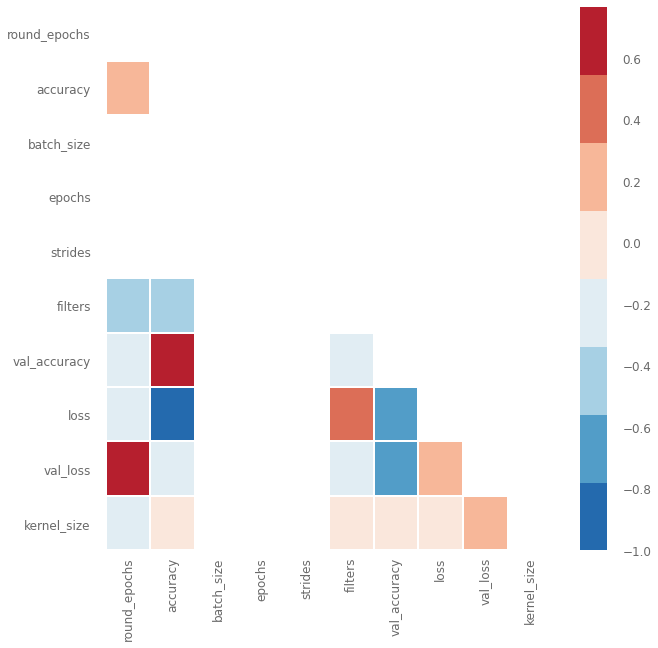

In [ ]:
a.plot_corr(metric='val_accuracy', exclude=[])

## extracting the parameters for the best model

In [ ]:
a.best_params(metric='val_accuracy', exclude=[], n=1)

array([[4, 0.9944958686828612, 100, 30, 1, 128, 'same',
        0.019772926345467567, 0.08177616447210312, 'RMSprop', 3, 0]],
      dtype=object)